In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**The recipe retrieval system from food image classification focuses on the categorization of food images into their respective classes and retrieving the recipes from the food image provided by the user. The work also aims to retrieve the recipes from the ingredients provided by the user. If the user is short of some ingredients, the model gives the best recipe to be cooked from those ingredients.  The system provides an interactive user interface for the recipe retrieval from food images as well as from the ingredients provided by the user.**


In [ ]:

import tensorflow as tf

import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from matplotlib.pyplot import imshow
import os
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML
import seaborn as sns
sns.set_style('darkgrid')



Importing Keras Library

In [ ]:
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [ ]:
class LRA(keras.callbacks.Callback):
    def __init__(self,model, base_model, patience,stop_patience, threshold, factor, dwell, batches, initial_epoch,epochs, ask_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.base_model=base_model
        self.patience=patience 
        self.stop_patience=stop_patience 
        self.threshold=threshold 
        self.factor=factor 
        self.dwell=dwell
        self.batches=batches
        self.initial_epoch=initial_epoch
        self.epochs=epochs
        self.ask_epoch=ask_epoch
        self.ask_epoch_initial=ask_epoch 
     
        self.count=0
        self.stop_count=0        
        self.best_epoch=1     
        self.initial_lr=float(tf.keras.backend.get_value(model.optimizer.lr))         
        self.highest_tracc=0.0
        self.lowest_vloss=np.inf 
        self.best_weights=self.model.get_weights()
        self.initial_weights=self.model.get_weights()   
        
    def on_train_begin(self, logs=None):        
        if self.base_model != None:
            status=base_model.trainable
            if status:
                msg=' initializing callback starting train with base_model trainable'
            else:
                msg='initializing callback starting training with base_model not trainable'
        else:
            msg='initialing callback and starting training'                        
        print(msg) 
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg) 
        self.start_time= time.time()
    def on_epoch_end(self, epoch, logs=None): 
        later=time.time()
        duration=later-self.now 
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr))
        current_lr=lr
        v_loss=logs.get('val_loss')  
        acc=logs.get('accuracy')
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')        
        if acc < self.threshold: 
            monitor='accuracy'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (acc-self.highest_tracc )*100/self.highest_tracc
            if acc>self.highest_tracc:               
                self.highest_tracc=acc 
                self.best_weights=self.model.get_weights()
                self.count=0 
                self.stop_count=0 
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.best_epoch=epoch + 1             
            else: 
                
              
                if self.count>=self.patience -1: 
                    color=(245, 170, 66)
                    lr= lr* self.factor 
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) 
                    self.count=0 
                    self.stop_count=self.stop_count + 1 
                    self.count=0 
                    if self.dwell:
                        self.model.set_weights(self.best_weights)                    
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1                
        else: 
            monitor='val_loss'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (self.lowest_vloss- v_loss )*100/self.lowest_vloss
            if v_loss< self.lowest_vloss: 
                self.lowest_vloss=v_loss               
                self.best_weights=self.model.get_weights()
                self.count=0  
                self.stop_count=0  
                color=(0,255,0)                
                self.best_epoch=epoch + 1 
            else:
                if self.count>=self.patience-1:
                    color=(245, 170, 66)
                    lr=lr * self.factor                  
                    self.stop_count=self.stop_count + 1
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) 
                    if self.dwell:
                        self.model.set_weights(self.best_weights)
                else: 
                    self.count =self.count +1                   
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        
    def on_train_end(self, logs=None):
        stop_time=time.time()
        tr_duration= stop_time- self.start_time            
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        self.model.set_weights(self.best_weights)
        msg=f'Training is completed - model is set with weights from epoch {self.best_epoch} '
        print(msg)
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)   
        
    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100 
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='')       
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training
        else: 
            if self.ask_epoch !=None:
                if epoch + 1 >= self.ask_epoch:
                    if base_model.trainable:
                        msg='enter H to halt  or an integer for number of epochs to run then ask again'
                    else:
                        msg='enter H to halt ,F to fine tune model, or an integer for number of epochs to run then ask again'
                    print(msg)
                    ans=input('')
                    if ans=='H' or ans=='h':
                        msg=f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training
                    elif ans == 'F' or ans=='f':
                        if base_model.trainable:
                            msg='base_model is already set as trainable'
                        else:
                            msg='setting base_model as trainable for fine tuning of model'
                            self.base_model.trainable=True
                        print(msg)
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print(msg)                         
                        self.count=0
                        self.stop_count=0                        
                        self.ask_epoch = epoch + 1 + self.ask_epoch_initial 
                        
                    else:
                        ans=int(ans)
                        self.ask_epoch +=ans
                        msg=f' training will continue until epoch ' + str(self.ask_epoch)                         
                        print(msg)
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print(msg) 

### Define a function to plot the training data

**Downloading the essential libraries to remove the ambiguity of image grid dataframe**

In [1]:
!pip install advertools
!pip install iterative-stratification
!pip install scikit-multilearn
!pip install indic-nlp-library

     |████████████████████████████████| 287 kB 4.9 MB/s 
     |████████████████████████████████| 264 kB 36.0 MB/s 
     |████████████████████████████████| 55 kB 2.9 MB/s 
     |████████████████████████████████| 47 kB 4.2 MB/s 
     |████████████████████████████████| 251 kB 33.4 MB/s 
     |████████████████████████████████| 87 kB 4.9 MB/s 
     |████████████████████████████████| 4.0 MB 49.4 MB/s 
     |████████████████████████████████| 3.1 MB 21.3 MB/s 
     |████████████████████████████████| 74 kB 3.1 MB/s 
  Created wheel for PyDispatcher: filename=PyDispatcher-2.0.5-py3-none-any.whl size=11516 sha256=4ce4313e96e3e445cd305d604342f2f5c779591765e2ab1eb5b42673e4dfce83
  Stored in directory: /root/.cache/pip/wheels/2d/18/21/3c6a732eaa69a339198e08bb63b7da2c45933a3428b29ec454
Successfully built PyDispatcher
     |████████████████████████████████| 89 kB 3.3 MB/s 
     |████████████████████████████████| 40 kB 3.7 MB/s 
     |████████████████████████████████| 2.8 MB 7.0 MB/s 


### define a function to create confusion matrix and classification report

In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names     
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print(msg)
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print(msg)
                              
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print(msg)
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n--\n", clr)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### define a function to save the model and  class_dict.csv file

In [ ]:
def saver(save_path, model, model_name, subject, accuracy,img_size, scalar, generator):
    save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
    model_save_loc=os.path.join(save_path, save_id)
    model.save(model_save_loc)
    print(model_save_loc) 
    # now create the class_df and convert to csv file    
    class_dict=generator.class_indices 
    height=[]
    width=[]
    scale=[]
    for i in range(len(class_dict)):
        height.append(img_size[0])
        width.append(img_size[1])
        scale.append(scalar)
    Index_series=pd.Series(list(class_dict.values()), name='class_index')
    Class_series=pd.Series(list(class_dict.keys()), name='class') 
    Height_series=pd.Series(height, name='height')
    Width_series=pd.Series(width, name='width')
    Scale_series=pd.Series(scale, name='scale by')
    class_df=pd.concat([Index_series, Class_series, Height_series, Width_series, Scale_series], axis=1)    
    csv_name='class_dict.csv'
    csv_save_loc=os.path.join(save_path, csv_name)
    class_df.to_csv(csv_save_loc, index=False) 
    print( csv_save_loc) 
    return model_save_loc, csv_save_loc

In [3]:
! pip install simpletransformers
from simpletransformers.classification import ClassificationModel
from transformers import AutoTokenizer

     |████████████████████████████████| 249 kB 4.2 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 1.2 MB 41.3 MB/s 
     |████████████████████████████████| 6.6 MB 30.0 MB/s 
     |████████████████████████████████| 1.8 MB 36.9 MB/s 
     |████████████████████████████████| 4.0 MB 37.6 MB/s 
     |████████████████████████████████| 10.1 MB 33.3 MB/s 
     |████████████████████████████████| 325 kB 48.7 MB/s 
     |████████████████████████████████| 77 kB 6.5 MB/s 
     |████████████████████████████████| 895 kB 52.6 MB/s 
     |████████████████████████████████| 596 kB 34.9 MB/s 
     |████████████████████████████████| 144 kB 51.3 MB/s 
     |████████████████████████████████| 181 kB 46.1 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 212 kB 18.3 MB/s 
     |████████████████████████████████| 136 kB 38.8 MB/s 
     |████████████████████████████████| 1.1 MB 43.5 MB/s 
     |██████████████

### define a function that uses the trained model and the
### class_dict.csv file to predict images

In [ ]:
def generate_matrix(df1,word2count):
  split_words = set()
  split_words=df1['sentence'].str.split()
  final_feature_matrix = []
  for data in split_words:
    temp = []
    for word in word2count:
        if word[0] in data:
            temp.append(data.count(word[0]))
        else:
            temp.append(0)
    final_feature_matrix.append(temp)
  final_feature_matrix = np.asarray(final_feature_matrix)
  df2=pd.DataFrame(final_feature_matrix)
  word_temp=[]
  for i in word2count:
    word_temp.append(i[0])
  df2.columns=word_temp
  return df2

In [ ]:
def predictor(sdir, csv_path,  model_path, averaged=True, verbose=True):    
    # read in the csv file
    class_df=pd.read_csv(csv_path)    
    class_count=len(class_df['class'].unique())
    img_height=int(class_df['height'].iloc[0])
    img_width =int(class_df['width'].iloc[0])
    img_size=(img_width, img_height)    
    scale=class_df['scale by'].iloc[0] 
    image_list=[]

    try: 
        s=int(scale)
        s2=1
        s1=0
    except:
        split=scale.split('-')
        s1=float(split[1])
        s2=float(split[0].split('*')[1])
    path_list=[]
    paths=os.listdir(sdir)    
    for f in paths:
        path_list.append(os.path.join(sdir,f))
    if verbose:
        print (' Model is being loaded- this will take about 10 seconds')
    model=load_model(model_path)
    image_count=len(path_list) 
    image_list=[]
    file_list=[]
    good_image_count=0
    for i in range (image_count):        
        try:
            img=cv2.imread(path_list[i])
            img=cv2.resize(img, img_size)
            img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)            
            good_image_count +=1
            img=img*s2 - s1             
            image_list.append(img)
            file_name=os.path.split(path_list[i])[1]
            file_list.append(file_name)
        except:
            if verbose:
                print ( path_list[i], ' is an invalid image file')
    if good_image_count==1:
        averaged=True
    image_array=np.array(image_list)    
    preds=model.predict(image_array)    
    if averaged:
        psum=[]
        for i in range (class_count):
            psum.append(0)    
        for p in preds: 
            for i in range (class_count):
                psum[i]=psum[i] + p[i]     
        index=np.argmax(psum)      
        klass=class_df['class'].iloc[index] 
        prob=psum[index]/good_image_count         
       
        for img in image_array:  #iterate through the images    
            test_img=np.expand_dims(img, axis=0) # since it is a single image expand dimensions 
            test_index=np.argmax(model.predict(test_img)) 
            if test_index== index: # see if this image has the same index as was selected previously
                if verbose: # show image and print result if verbose=1
                    plt.axis('off')
                    plt.imshow(img) # show the image
                    print (f'predicted species is {klass} with a probability of {prob:6.4f} ')
                break # found an image that represents the predicted class      
        return klass, prob, img, None
    else: # create individual predictions for each image
        pred_class=[]
        prob_list=[]
        for i, p in enumerate(preds):
            index=np.argmax(p) # find the class index with the highest probability sum
            klass=class_df['class'].iloc[index] 
            image_file= file_list[i]
            pred_class.append(klass)
            prob_list.append(p[index])            
        Fseries=pd.Series(file_list, name='image file')
        Lseries=pd.Series(pred_class, name= 'species')
        Pseries=pd.Series(prob_list, name='probability')
        df=pd.concat([Fseries, Lseries, Pseries], axis=1)
        if verbose:
            length= len(df)
            print (df.head(length))
        return None, None, None, df

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

(3456, 3456, 3)


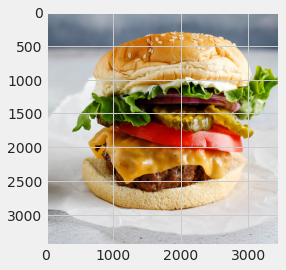

In [ ]:
img_path=r'/content/drive/MyDrive/IR Project/Data/FoodImage(20Classes)/Food Classification/burger/001.jpg'



### Preprocessing of the dataframe

In [ ]:
def preprocess (sdir, trsplit, vsplit, random_seed):
    filepaths=[]
    labels=[]    
    classlist=os.listdir(sdir)
    for klass in classlist:
        classpath=os.path.join(sdir,klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            if f.endswith(".png"):
                os.remove(fpath)
            filepaths.append(fpath)
            labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1)       
    # split df into train_df and test_df 
    dsplit=vsplit/(1-trsplit)
    strat=df['labels']    
    train_df, dummy_df=train_test_split(df, train_size=trsplit, shuffle=True, random_state=random_seed, stratify=strat)
    strat=dummy_df['labels']
    valid_df, test_df=train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=random_seed, stratify=strat)
    print('train_df length: ', len(train_df), '  test_df length: ',len(test_df), '  valid_df length: ', len(valid_df))
    print(train_df['labels'].value_counts())
    return train_df, test_df, valid_df
    

In [ ]:
sdir=r'/content/drive/MyDrive/IR Project/Data/FoodImage(20Classes)/Food Classification'
train_df, test_df, valid_df= preprocess(sdir, .8,.1, 123)

train_df length:  7868   test_df length:  984   valid_df length:  984
chapati            330
kadai_paneer       330
chole_bhature      329
chai               305
fried_rice         284
pav_bhaji          282
butter_naan        263
dal_makhani        257
momos              255
masala_dosa        249
idli               248
burger             247
jalebi             237
kaathi_rolls       234
dhokla             231
pakode             222
samosa             210
pizza              209
butter_chicken     191
kulfi              190
gobi_sabzi         184
steamed_rice       176
egg_curry          175
paneer_tikka       174
noodles            173
ras_malai          169
soya_chaap         161
laddoo             148
aalo_puri          146
chilli_potato      146
munchurian         145
dahi_bhalla        143
medu_vada          142
chicken_biryani    139
rajma_chawal       116
bread_pakora       115
bhel_puri          111
paani_puri         104
omlet               98
Name: labels, dtype: int64


In [4]:
! pip install simpletransformers

In [ ]:
max_samples= 238
min_samples=0
column='labels'
working_dir = r'/content/drive/MyDrive/IR Project/Data/FoodImage(20Classes)/Food Classification'
img_size=(224,224)
ndf=balance(train_df,max_samples, min_samples, column, working_dir, img_size)

[238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 237, 234, 231, 222, 210, 209, 191, 190, 184, 176, 175, 174, 173, 169, 161, 148, 146, 146, 145, 143, 142, 139, 116, 115, 111, 104, 98]
Found 189 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 3 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 181 validated image filenames.
Found 174 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 6 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 155 validated image filenames.
Found 231 validated image filenames.
Found 222 validated image filenames.
Found 234 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 8 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 138 validated image filenames.
Found 139 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 144 validated image filenames.
Found 141 validated image filenames.
Found 115 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 7 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 138 validated image filenames.
Found 139 validated image filenames.
Found 175 validated image filenames.
Found 141 validated image filenames.
Found 209 validated image filenames.
Found 237 validated image filenames.
Found 210 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 5 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 171 validated image filenames.
Found 98 validated image filenames.
Found 111 validated image filenames.
Found 186 validated image filenames.
Found 162 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 4 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 169 validated image filenames.
Found 104 validated image filenames.
Found 115 validated image filenames.
Total Augmented images created=  1937
[238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238]


In [ ]:
channels=3
batch_size=30
img_shape=(img_size[0], img_size[1], channels)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)


test batch size:  41   test steps:  24


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 62 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 9220 validated image filenames belonging to 39 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 983 validated image filenames belonging to 39 classes.
Found 977 validated image filenames belonging to 39 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 7 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()


In [ ]:
def scalar(img):    
    return img  # EfficientNet expects pixelsin range 0 to 255 so no scaling is required
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=trgen.flow_from_dataframe( ndf, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(np.ceil(len(train_gen.labels)/batch_size))

In [7]:
pip install keras-transformer-xl

  Created wheel for keras-transformer-xl: filename=keras_transformer_xl-0.14.0-py3-none-any.whl size=19889 sha256=ea7a6c5ee3ef562a07ecf5578eee4dc76e075366eb51fdbeb05563640a9fea91
  Stored in directory: /root/.cache/pip/wheels/08/fe/74/84884f2e7940967d0e530a4ad62f209910f364b352b2bb1eb1
  Created wheel for keras-adaptive-softmax: filename=keras_adaptive_softmax-0.9.0-py3-none-any.whl size=19519 sha256=b482132b2e71003e486f813098ac1a1156e9c7fb08cfe15ad6174909cef99819
  Stored in directory: /root/.cache/pip/wheels/5d/3c/db/6e38bc20c1d28c2c80fd21dfc535535098845a84e3a568734c
Successfully built keras-transformer-xl keras-adaptive-softmax


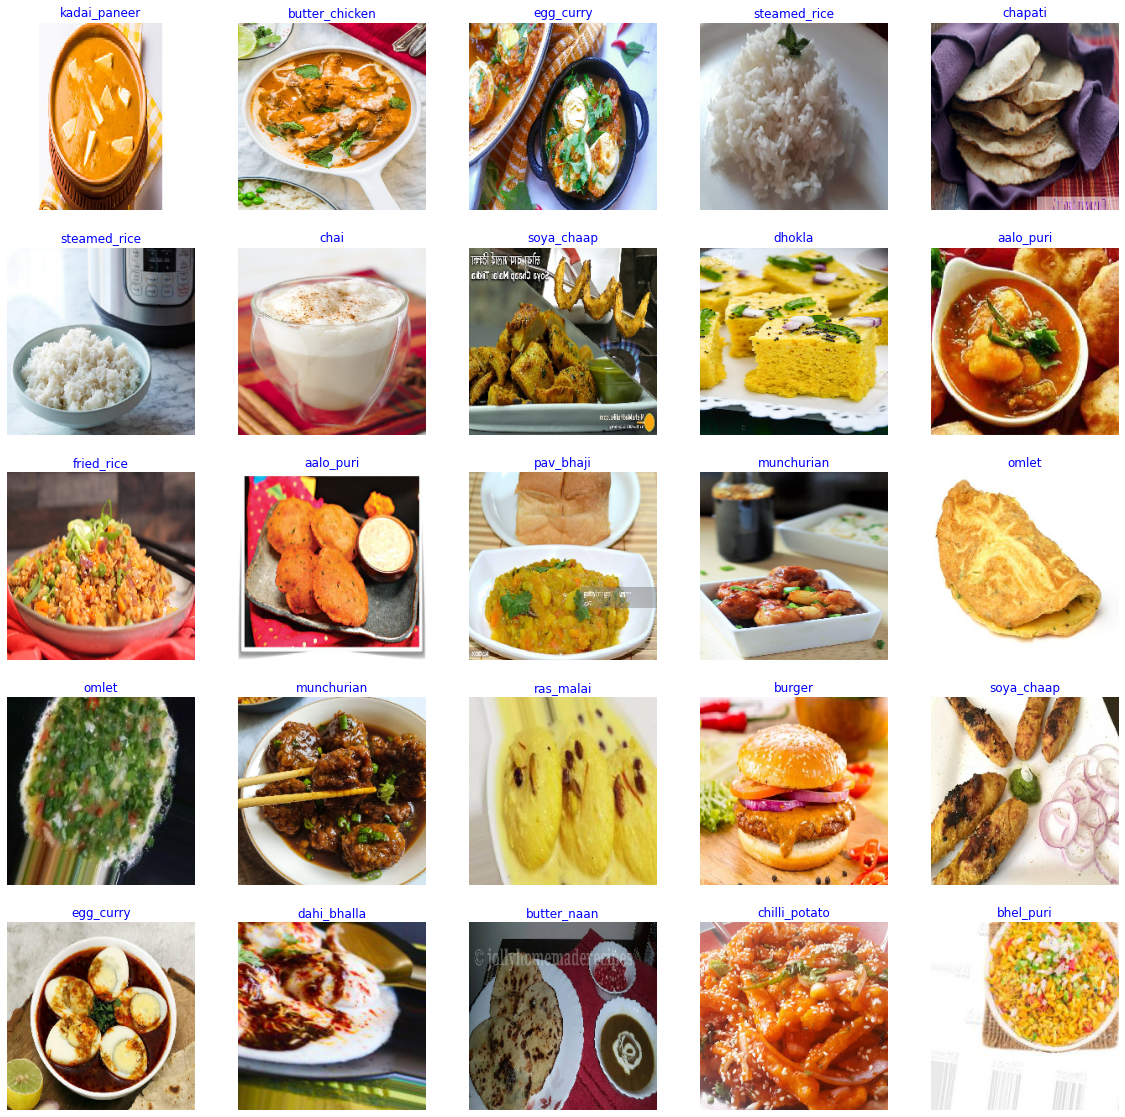

In [ ]:
show_image_samples(train_gen)


### create the model

In [ ]:
model_name='EfficientNetB2'
base_model=tf.keras.applications.EfficientNetB2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

31801344/31790344 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


In [6]:
!pip install keras-transformer

  Created wheel for keras-transformer: filename=keras_transformer-0.40.0-py3-none-any.whl size=12305 sha256=e47ba1ea19e257812b9e5ba0ceaeaf66301b65d4dd4756c54a34c21d220521e3
  Stored in directory: /root/.cache/pip/wheels/46/68/26/692ed21edd832833c3b0a0e21615bcacd99ca458b3f9ed571f
  Created wheel for keras-embed-sim: filename=keras_embed_sim-0.10.0-py3-none-any.whl size=3960 sha256=56d6c109da4198cdea54358e2ba4d3a9ef4532db19678971679eeec42ad06cea
  Stored in directory: /root/.cache/pip/wheels/81/67/b5/d847588d075895281e1cf5590f819bd4cf076a554872268bd5
  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.16.0-py3-none-any.whl size=4668 sha256=7524434473fa72817232342d270949ed2cd39ceda610c89673ee99deaa84be3e
  Stored in directory: /root/.cache/pip/wheels/85/5d/1c/2e619f594f69fbcf8bc20943b27d414871c409be053994813e
  Created wheel for keras-multi-head: filename=keras_multi_head-0.29.0-py3-none-any.whl size=14993 sha256=4efb12f1c73dd1d0f40b184108f0c338995320e29990

### instantiate the custom callback and train the model

In [ ]:
epochs =40
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch= 6# number of epochs to run before asking if you want to halt training
batches=train_steps
callbacks=[LRA(model=model,base_model= base_model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 initializing callback starting train with base_model trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration



/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


 1 /40     8.100   46.594   5.49470  78.506   0.00100  0.00100  accuracy     0.00   1771.30 

 2 /40     4.409   80.195   3.32312  83.930   0.00100  0.00100  accuracy    72.11    228.49 

 3 /40     2.605   88.482   2.10993  86.387   0.00100  0.00100  accuracy    10.33    226.11 

 4 /40     1.633   92.082   1.48788  87.718   0.00100  0.00100  val_loss    29.48    229.31 

 5 /40     1.109   95.054   1.19477  87.410   0.00100  0.00100  val_loss    19.70    224.96 

 6 /40     0.849   95.954   1.04522  87.615   0.00100  0.00100  val_loss    12.52    225.47 

enter H to halt  or an integer for number of epochs to run then ask again

4
 training will continue until epoch 10

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 7 /40     0.709   96.952   0.95998  88.639   0.00100  0.00100  val_loss     8.15    224.99 

 8 /40     0.604   98.134   0.94081  87.001   0.00100  0.00100  val_loss     2.00    226.68 

 9 /40     0.532   98.590   0.85301  8

In [9]:
!pip install transformers[Flax]

     |████████████████████████████████| 140 kB 5.4 MB/s 
     |████████████████████████████████| 184 kB 34.2 MB/s 
     |████████████████████████████████| 72 kB 505 kB/s 


### evaluate model on the test set then save the model

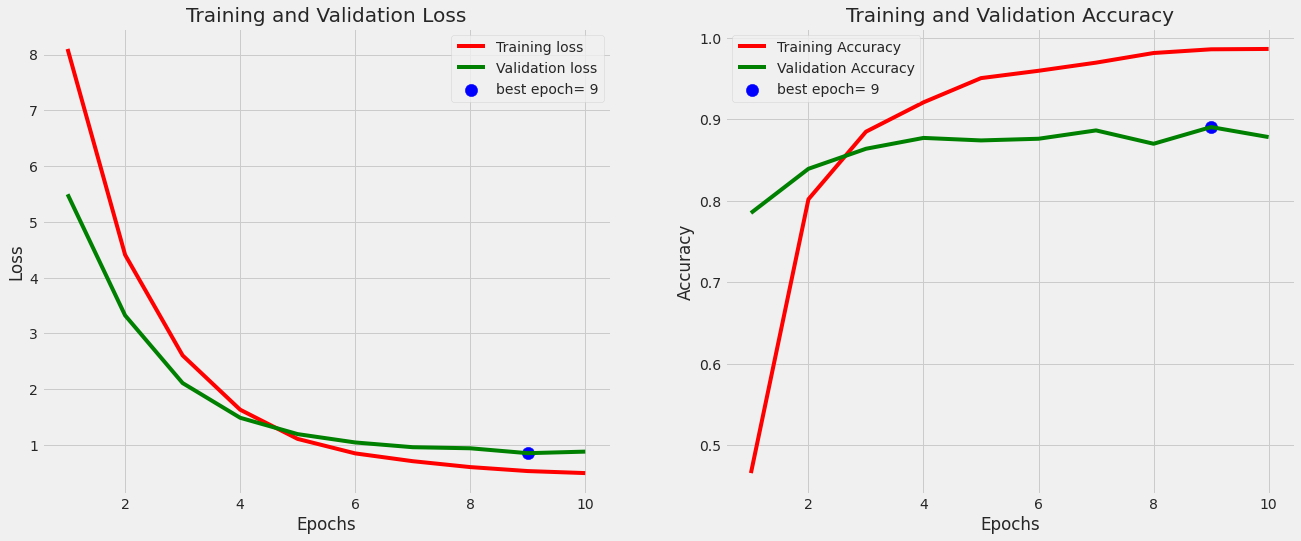

24/24 [==============================] - 250s 11s/step - loss: 0.9229 - accuracy: 0.8688
accuracy on the test set is 86.88 %

model was saved as /content/drive/MyDrive/IR Project/Data/FoodImage(20Classes)/Food Classification/EfficientNetB2-indian food-86.87.h5

class csv file was saved as /content/drive/MyDrive/IR Project/Data/FoodImage(20Classes)/Food Classification/class_dict.csv



In [ ]:
tr_plot(history,0)
subject='indian food'
acc=model.evaluate( test_gen, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print(msg)
generator=train_gen
scale = 1
model_save_loc, csv_save_loc=saver(working_dir, model, model_name, subject, acc, img_size, scale,  generator)

### make predictions on test set and generate confusion matrix and classification report

24/24 [==============================] - 24s 906ms/step
Classification Report:
----------------------
                  precision    recall  f1-score   support

      aalo_puri       0.88      0.78      0.82        18
      bhel_puri       0.73      0.79      0.76        14
   bread_pakora       0.79      1.00      0.88        15
         burger       0.94      0.94      0.94        31
 butter_chicken       0.78      0.75      0.77        24
    butter_naan       0.91      0.88      0.89        33
           chai       0.95      0.92      0.93        38
        chapati       0.88      0.69      0.77        42
chicken_biryani       0.81      0.76      0.79        17
  chilli_potato       1.00      0.78      0.88        18
  chole_bhature       0.83      0.93      0.87        41
    dahi_bhalla       0.81      0.94      0.87        18
    dal_makhani       0.86      0.97      0.91        32
         dhokla       0.96      0.90      0.93        29
      egg_curry       0.91      0.95     

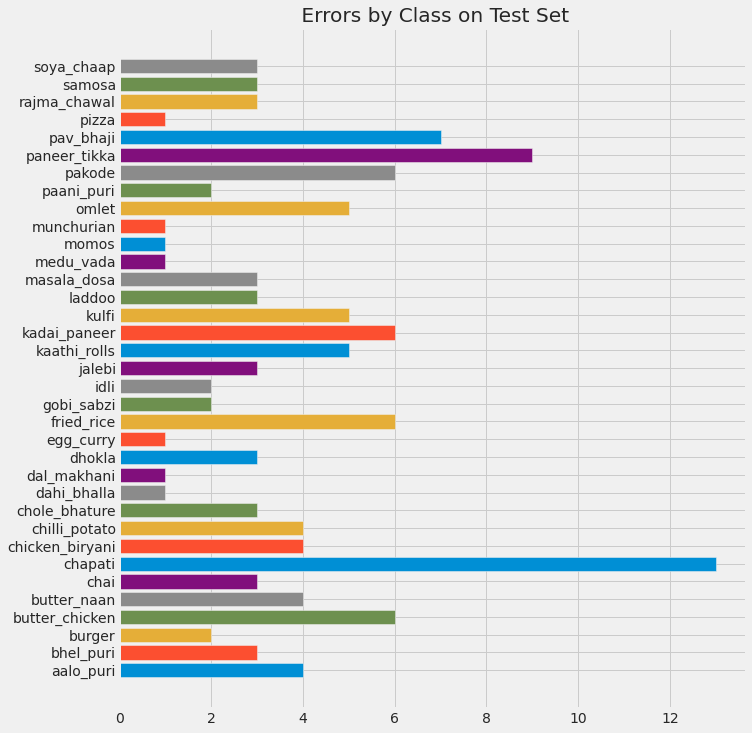

In [ ]:
print_code=0
preds=model.predict(test_gen, steps=test_steps, verbose=1) 
print_info( test_gen, preds, print_code, working_dir, subject )  

### use the predictor function to classify the single image

 image is of class egg_curry with a probability of  96.69 %


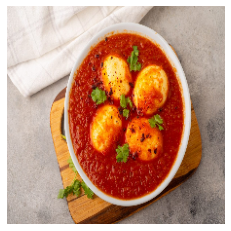

In [ ]:
# csv_path=csv_save_loc # path to class_dict.csv
csv_path = '/content/drive/MyDrive/IR Project/Data/FoodImage(20Classes)/Food Classification/class_dict.csv'
# model_path=model_save_loc # path to the trained model
model_path = '/content/drive/MyDrive/IR Project/Data/FoodImage(20Classes)/Food Classification/EfficientNetB2-indian food-86.87.h5'
store_path = '/content/drive/MyDrive/IR Project/Data/FoodImage(20Classes)/Food Classification/storage'
klass, prob, img, df =predictor(store_path, csv_path,  model_path, averaged=True, verbose=False) # run the classifier
msg=f' image is of class {klass} with a probability of {prob * 100: 6.2f} %'
plt.axis('off')
plt.imshow(img)
print(msg)